<a href="https://colab.research.google.com/github/amratanshcode/Deep-learning-project-with-cv/blob/main/Brain_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os # directoy
import numpy as np # for numerical operations
import random
from PIL import Image,ImageEnhance #for image processing and enhancement

In [19]:
# import modals from keras
from tensorflow.keras.models import Sequential # for build the model
from tensorflow.keras.layers import Input, Flatten,Dropout,Dense  # for model layers
from tensorflow.keras.preprocessing.image import load_img # for loading images
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16 # transfer learning
from sklearn.utils import shuffle  # for shuffling the class


## Load my dataset for train and **test**

In [47]:
# Directories
train_dir = '/content/drive/MyDrive/ml tumor dataset/Training'
test_dir = '/content/drive/MyDrive/ml tumor dataset/Testing'
#load & shufle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir,label)):
    train_paths.append(os.path.join(train_dir,label,image))
    train_labels.append(label)
    train_paths,train_labels = shuffle(train_paths,train_labels)

#load & shuffle the test data

test_paths = []
test_labels = []
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir,label)):
    test_paths.append(os.path.join(test_dir,label,image))
    test_labels.append(label)

test_paths,test_labels = shuffle(test_paths,test_labels)




# Data **visualization**

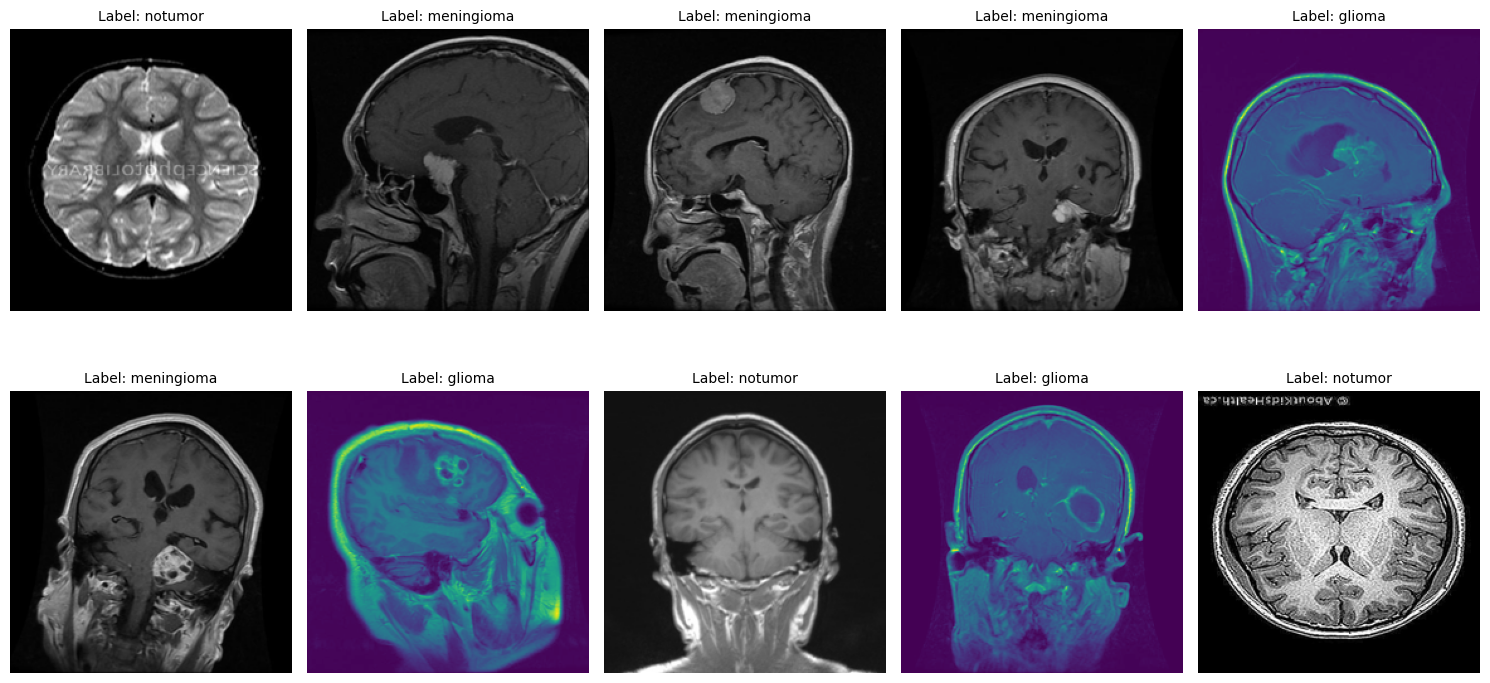

In [9]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()


# Image Processing

In [32]:
def augment_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
  image =np.array(image)/255.0
  return image
#Load images and apply
def open_images(paths):
  images = []
  for path in paths:
    img = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
    img =augment_image(img)
    images.append(img)
  return np.array(images) # The return was inside the loop, moved outside
#ENcoder lebels(convert label names to integers)
def encode_label(labels):
  # Get unique labels once when the function is called instead of getting it on every call
  if not hasattr(encode_label, "unique_labels"):
    encode_label.unique_labels = os.listdir(train_dir)
  # encoding process to be applied to labels list
  encoded =  [encode_label.unique_labels.index(label) for label in labels]
  return np.array(encoded)
#Data generator for batching
def datagen(paths,labels,batch_size=12,epochs=1):
   for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [ ]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1021s 4s/step - loss: 0.6564 - sparse_categorical_accuracy: 0.7410
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 908s 3s/step - loss: 0.2575 - sparse_categorical_accuracy: 0.9090
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 904s 3s/step - loss: 0.1627 - sparse_categorical_accuracy: 0.9372
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 909s 3s/step - loss: 0.1245 - sparse_categorical_accuracy: 0.9519
Epoch 5/5
246/285 ━━━━━━━━━━━━━━━━━━━━ 2:03 3s/step - loss: 0.1011 - sparse_categorical_accuracy: 0.9637

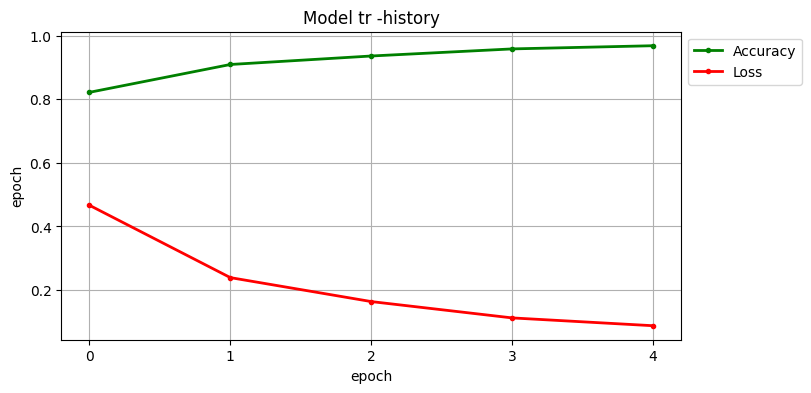

In [33]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'],'.g-',linewidth=2)
plt.plot(history.history['loss'],'.r-',linewidth=2)
plt.title("Model tr -history")
plt.xlabel('epoch')
plt.ylabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy','Loss'],loc='upper left',bbox_to_anchor=(1,1))
plt.show()

# **Model Classification Report**

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       405
           1       0.90      0.99      0.94       300
           2       0.95      0.86      0.91       306
           3       0.96      0.95      0.96       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



# **MOdel Confusion Matrix **

Confusion Matrix:
[[404   1   0   0]
 [  0 298   2   0]
 [  3  28 264  11]
 [  0   4  11 285]]


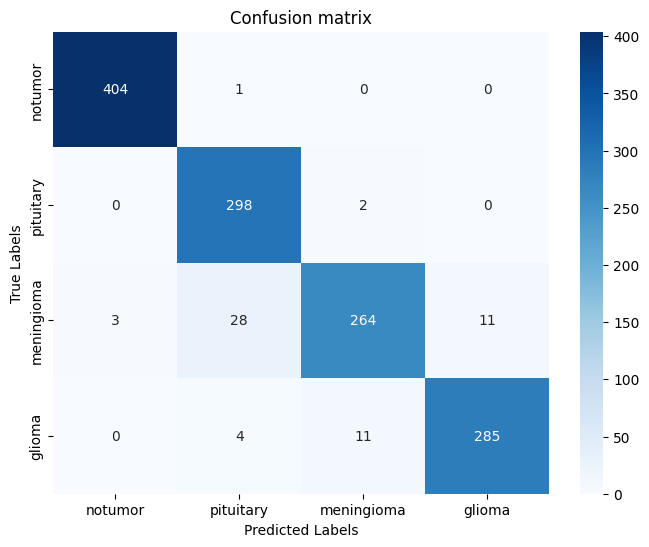

In [35]:
# Confusion matrix

conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)
#Plot the Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,annot=True,fmt="d",cmap="Blues",xticklabels=os.listdir(train_dir),yticklabels=os.listdir(train_dir))
plt.title("Confusion matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# **ROc CURVE Plot**

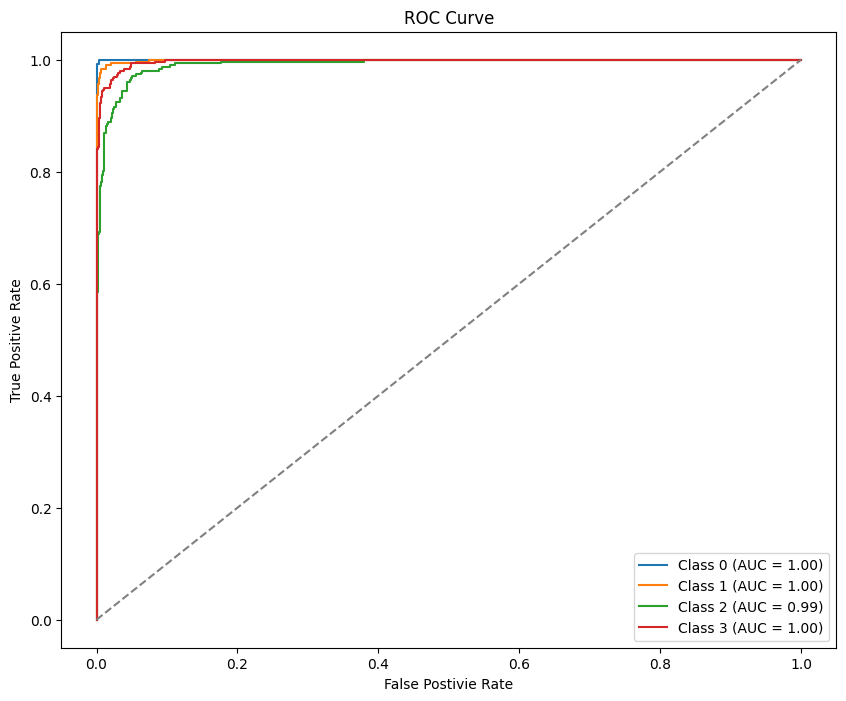

In [40]:
# ROC Curve and AUC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot the ROC curve
plt.figure(figsize=(10,8))
for i in range(len(os.listdir(train_dir))):
  plt.plot(fpr[i],tpr[i],label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],linestyle='--',color='gray')
plt.title('ROC Curve')
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc ='lower right')
plt.show()

# **Save and load that model**

In [28]:
model.save('model.h5')

In [29]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

Main work - MRI TUmor Detection  system ( prediction onthe baiss of given data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


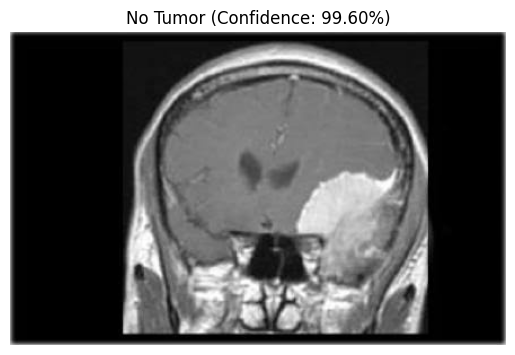

In [41]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


# Example 1) Image
image_path = '/content/drive/MyDrive/ml tumor dataset/Testing/meningioma/Te-meTr_0000.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


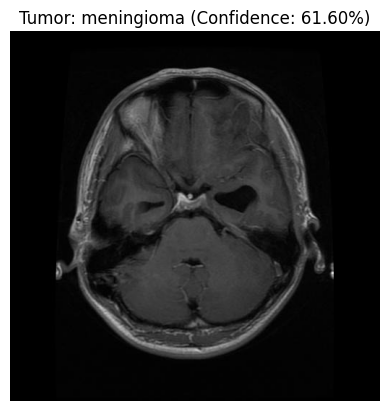

In [42]:
image_path = '/content/drive/MyDrive/ml tumor dataset/Testing/glioma/Te-glTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


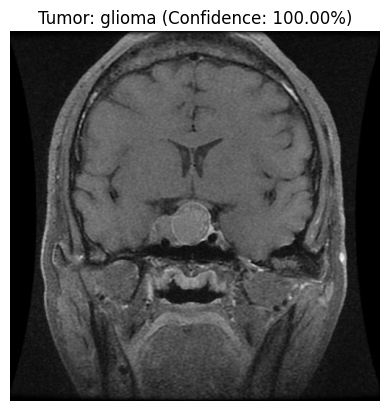

In [45]:
# Example usage
image_path = '/content/drive/MyDrive/ml tumor dataset/Testing/pituitary/Te-pi_0047.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


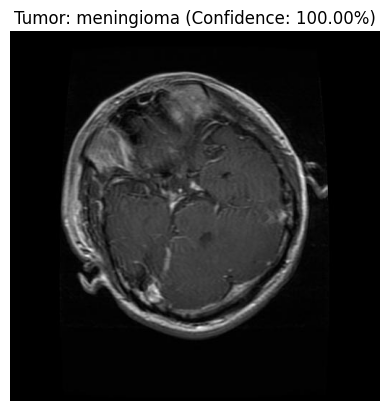

In [46]:
image_path ='/content/drive/MyDrive/ml tumor dataset/Testing/glioma/Te-glTr_0006.jpg'
detect_and_display(image_path, model)